In [2]:
import utils
import torch
from models import GAT, SpGAT
import torch.nn.functional as F
import sklearn.metrics
import numpy as np
from torch.autograd import Variable
import pandas as pd

In [7]:
adj, features, labels, idx_train, idx_val, idx_test = utils.load_joshi_data("Cd8a")
features, adj, labels = Variable(features), Variable(adj), Variable(labels)

 loading from cache file../data/graphs/stringdb_coex_mouse_graph_coexpression_edges.adjlist


In [8]:
features.shape

torch.Size([1630, 176, 1])

In [9]:
model = GAT(ncells = features.shape[0], #features is cells x gene x gene features
                ngenes=features.shape[1], 
                nfeat=features.shape[2],
                nhid=1, 
                nclass=1, # regression
                dropout=0.6, 
                nheads=1, 
                alpha=0.2)

model

GAT(
  (out_att): GraphAttentionLayer (1 -> 1)
)

In [10]:
torch.load('175.pkl')

OrderedDict([('out_att.W', tensor([[0.0213]], device='cuda:0')),
             ('out_att.a',
              tensor([[-5.5911e-07,  5.0033e-06],
                      [-1.8620e-08,  4.8852e-06],
                      [-2.6369e-06,  7.7814e-08],
                      ...,
                      [-1.2533e-06, -3.1838e-06],
                      [-1.2923e-06, -6.5209e-06],
                      [ 2.7277e-07, -3.4273e-06]], device='cuda:0'))])

In [32]:
model.load_state_dict(torch.load('175.pkl'))

<All keys matched successfully>

In [47]:
output_test[idx_test]

tensor([1.0212, 1.0307, 0.9450,  ..., 1.0811, 0.8198, 0.8157],
       grad_fn=<ViewBackward>)

In [33]:
def compute_test():
    model.eval()
    output = model(features, adj).reshape(-1)
    loss_test = F.smooth_l1_loss(output[idx_test], labels[idx_test].float()).float()
    r2_test = sklearn.metrics.r2_score(labels[idx_test].cpu(), output[idx_test].cpu().detach().numpy())
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.data.item()),
          "r2_test= {:.4f}".format(r2_test))
    
    return (output, labels)

In [34]:
output, labels = compute_test()

h torch.Size([1630, 176, 1])
W torch.Size([1, 1])
hW torch.Size([1630, 176, 1])
a_input torch.Size([1630, 176, 176, 2])
self.a torch.Size([1630, 2])
Test set results: loss= 0.0094 r2_test= 0.4107


In [5]:
pd.read_pickle("../data/joshi_processing/week8_ln_notebook_state.pkl")

<module '__main__'>

In [39]:
idx_test_mask = [True if l in idx_test.numpy() else False for l in range(labels.shape[0])]

In [40]:
ensembl_Cd8a = "ENSMUSG00000053977"

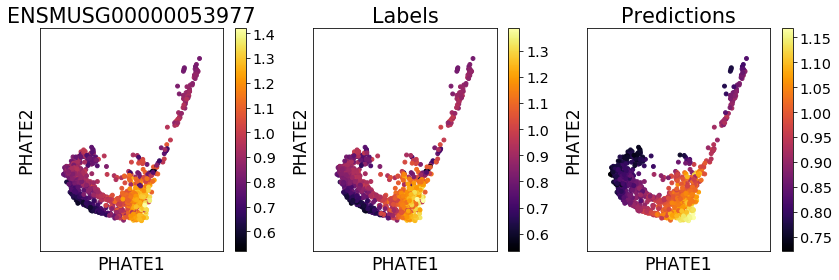

In [44]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
scprep.plot.scatter2d(data_phate_pc, ax=axes[0],fontsize=12, s=15, 
                      c=scprep.select.select_cols(data_magic_filt, exact_word=ensembl_Cd8a), 
                     title=ensembl_Cd8a, ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc, ax=axes[1],fontsize=12, s=15, 
                      c=labels.detach().numpy(), title="Labels",ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc, ax=axes[2],fontsize=12, s=15, 
                      c=output.detach().numpy(), title="Predictions",
                      ticks=False, label_prefix="PHATE")
plt.tight_layout()

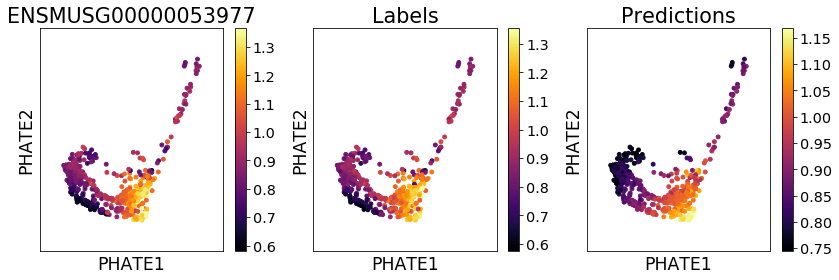

In [50]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
scprep.plot.scatter2d(data_phate_pc[idx_test_mask], ax=axes[0],fontsize=12, s=15, 
                      c=scprep.select.select_cols(data_magic_filt[idx_test_mask], exact_word=ensembl_Cd8a), 
                     title=ensembl_Cd8a, ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc[idx_test_mask], ax=axes[1],fontsize=12, s=15, 
                      c=labels.detach().numpy()[idx_test_mask], title="Labels",ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc[idx_test_mask], ax=axes[2],fontsize=12, s=15, 
                      c=output.detach().numpy()[idx_test_mask], title="Predictions",
                      ticks=False, label_prefix="PHATE")
plt.tight_layout()